In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

from math import sqrt
from numpy import concatenate

In [15]:
# load df for lstm model
# inputs: stock group ID, revenue, time
# inner join invoice ID, stock ID
# str_sql = '''
# SELECT invoices.InvoiceDate, (invoicelines.Quantity * invoicelines.UnitPrice) AS Revenue, stockitemstockgroups.StockItemID, stockitemstockgroups.StockGroupID, stockitemholdings.LastCostPrice AS CostPrice
# FROM invoicelines
#     INNER JOIN invoices ON invoicelines.InvoiceID = invoices.ï»¿InvoiceID
#     INNER JOIN stockitemstockgroups ON invoicelines.StockItemID = stockitemstockgroups.StockItemID
#     INNER JOIN stockitemholdings ON invoicelines.StockItemID = stockitemholdings.StockItemID
# ORDER BY invoices.ï»¿InvoiceID ASC;
# '''
# inputs_df = pd.read_sql(sql=str_sql, con=db_wwi)
# inputs_df
# inputs_df.to_csv('data_with_stockItemID.csv', index=False)

In [2]:
ini_df = pd.read_csv('denormalised.csv')
ini_df

,Unnamed: 0,InvoiceLineID,InvoiceID,StockItemID,CustomerID,Quantity,UnitPrice,InvoiceDate,InvoiceDateYear,InvoiceDateMonth,...,InvoiceDateWeek,StockItemName,StockGroupID,StockGroupName,Brand,Size,CostPrice,CustomerName,CustomerCategoryID,CustomerCategoryName
0,0,1,1,67,832,10,230.0,2013-01-01,2013,1,...,0,Ride on toy sedan car (Black) 1/12 scale,1,Novelty Items,Northwind,1/12 scale,145.0,Aakriti Byrraju,4,Supermarket
1,1,1,1,67,832,10,230.0,2013-01-01,2013,1,...,0,Ride on toy sedan car (Black) 1/12 scale,9,Toys,Northwind,1/12 scale,145.0,Aakriti Byrraju,4,Supermarket
2,2,2,2,50,803,9,13.0,2013-01-01,2013,1,...,0,Developer joke mug - old C developers never di...,1,Novelty Items,NaN,NaN,4.5,Bala Dixit,3,Novelty Shop
3,3,2,2,50,803,9,13.0,2013-01-01,2013,1,...,0,Developer joke mug - old C developers never di...,3,Mugs,NaN,NaN,4.5,Bala Dixit,3,Novelty Shop
4,4,2,2,50,803,9,13.0,2013-01-01,2013,1,...,0,Developer joke mug - old C developers never di...,6,Computing Novelties,NaN,NaN,4.5,Bala Dixit,3,Novelty Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309289,309289,156390,48177,53,1024,6,13.0,2015-05-30,2015,5,...,21,IT joke mug - keyboard not found … press F1 to...,3,Mugs,NaN,NaN,4.5,Arka Chatterjee,4,Supermarket
309290,309290,156390,48177,53,1024,6,13.0,2015-05-30,2015,5,...,21,IT joke mug - keyboard not found … press F1 to...,6,Computing Novelties,NaN,NaN,4.5,Arka Chatterjee,4,Supermarket
309291,309291,156391,48178,214,847,1,90.0,2015-05-30,2015,5,...,21,Air cushion film 200mmx200mm 325m,10,Packaging Materials,NaN,325m,54.0,Kristiina Ivanov,5,Computer Store
309292,309292,156392,48178,61,847,8,25.0,2015-05-30,2015,5,...,21,RC toy sedan car with remote control (Green) 1...,1,Novelty Items,Northwind,1/50 scale,12.5,Kristiina Ivanov,5,Computer Store


In [4]:
df_revenue = ini_df.loc[:, ['Quantity', 'UnitPrice', 'InvoiceDateYear', 'InvoiceDateMonth', 'StockItemID', 'StockGroupID','CustomerCategoryID']]
df_revenue['Revenue'] = df_revenue.Quantity * df_revenue.UnitPrice

df_revenue.drop(["Quantity", "UnitPrice"], axis = 1, inplace= True)
df_revenue = pd.get_dummies(df_revenue, columns=['CustomerCategoryID'])
df_revenue

,InvoiceDateYear,InvoiceDateMonth,StockItemID,StockGroupID,Revenue,CustomerCategoryID_3,CustomerCategoryID_4,CustomerCategoryID_5,CustomerCategoryID_6,CustomerCategoryID_7
0,2013,1,67,1,2300.0,0,1,0,0,0
1,2013,1,67,9,2300.0,0,1,0,0,0
2,2013,1,50,1,117.0,1,0,0,0,0
3,2013,1,50,3,117.0,1,0,0,0,0
4,2013,1,50,6,117.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
309289,2015,5,53,3,78.0,0,1,0,0,0
309290,2015,5,53,6,78.0,0,1,0,0,0
309291,2015,5,214,10,90.0,0,0,1,0,0
309292,2015,5,61,1,200.0,0,0,1,0,0


In [5]:
df_revenue_agg = df_revenue.groupby(['StockGroupID', 'StockItemID', 'InvoiceDateYear', 'InvoiceDateMonth' ]).sum()
df_revenue_agg

Revenue  \
StockGroupID StockItemID InvoiceDateYear InvoiceDateMonth             
1            1           2013            1                   3275.0   
                                         2                   2600.0   
                                         3                   2875.0   
                                         4                   3100.0   
                                         5                   2975.0   
...                                                             ...   
10           219         2015            1                 102000.0   
                                         2                  70000.0   
                                         3                  64500.0   
                                         4                  77500.0   
                                         5                  48000.0   

                                                           CustomerCategoryID_3  \
StockGroupID StockItemID InvoiceDateYear InvoiceDateMonth                         
1            1           2013            1                                   11   
                                         2                                   12   
                                         3                                   12   
                                         4                                   16   
                                         5                                   17   
...                                                                         ...   
10           219         2015            1                                   25   
                                         2                                   18   
                                         3                                   15   
                                         4                                   20   
                                         5                                   16   

                                                           CustomerCategoryID_4  \
StockGroupID StockItemID InvoiceDateYear InvoiceDateMonth                         
1            1           2013            1                                    6   
                                         2                                    1   
                                         3                                    3   
                                         4                                    2   
                                         5                                    1   
...                                                                         ...   
10           219         2015            1                                    2   
                                         2                                    2   
                                         3                                    0   
                                         4                                    0   
                                         5                                    1   

                                                           CustomerCategoryID_5  \
StockGroupID StockItemID InvoiceDateYear InvoiceDateMonth                         
1            1           2013            1                                    1   
                                         2                                    1   
                                         3                                    6   
                                         4                                    0   
                                         5                                    2   
...                                                                         ...   
10           219         2015            1                                    0   
                                         2                                    2   
                                         3                                    3   
                                         4                     

In [6]:
df_features = ini_df[['StockItemID', 'StockGroupID', 'CostPrice']] #brand alot none
df_features.drop_duplicates()
df_features

,StockItemID,StockGroupID,CostPrice
0,67,1,145.0
1,67,9,145.0
2,50,1,4.5
3,50,3,4.5
4,50,6,4.5
...,...,...,...
309289,53,3,4.5
309290,53,6,4.5
309291,214,10,54.0
309292,61,1,12.5


In [16]:
df2 = df_revenue_agg.reset_index().merge(df_features, on = ['StockItemID','StockGroupID' ], how = 'left').drop_duplicates()
df2

,StockGroupID,StockItemID,InvoiceDateYear,InvoiceDateMonth,Revenue,CustomerCategoryID_3,CustomerCategoryID_4,CustomerCategoryID_5,CustomerCategoryID_6,CustomerCategoryID_7,CostPrice
0,1,1,2013,1,3275.0,11,6,1,0,4,9.5
727,1,1,2013,2,2600.0,12,1,1,3,5,9.5
1454,1,1,2013,3,2875.0,12,3,6,0,1,9.5
2181,1,1,2013,4,3100.0,16,2,0,1,3,9.5
2908,1,1,2013,5,2975.0,17,1,2,1,1,9.5
...,...,...,...,...,...,...,...,...,...,...,...
8966081,10,219,2015,1,102000.0,25,2,0,5,1,26.0
8966770,10,219,2015,2,70000.0,18,2,2,0,3,26.0
8967459,10,219,2015,3,64500.0,15,0,3,2,2,26.0
8968148,10,219,2015,4,77500.0,20,0,3,2,2,26.0


In [17]:
df2['CustomerCount'] = df2['CustomerCategoryID_3'] + df2['CustomerCategoryID_4'] + df2['CustomerCategoryID_5'] + df2['CustomerCategoryID_6'] + df2['CustomerCategoryID_7']
df2['CustomerCategoryID_3'] = df2['CustomerCategoryID_3'] / df2['CustomerCount'] 
df2['CustomerCategoryID_4'] = df2['CustomerCategoryID_4'] / df2['CustomerCount'] 
df2['CustomerCategoryID_5'] = df2['CustomerCategoryID_5'] / df2['CustomerCount'] 
df2['CustomerCategoryID_6'] = df2['CustomerCategoryID_6'] / df2['CustomerCount'] 
df2['CustomerCategoryID_7'] = df2['CustomerCategoryID_7'] / df2['CustomerCount'] 
df2

,StockGroupID,StockItemID,InvoiceDateYear,InvoiceDateMonth,Revenue,CustomerCategoryID_3,CustomerCategoryID_4,CustomerCategoryID_5,CustomerCategoryID_6,CustomerCategoryID_7,CostPrice,CustomerCount
0,1,1,2013,1,3275.0,0.500000,0.272727,0.045455,0.000000,0.181818,9.5,22
727,1,1,2013,2,2600.0,0.545455,0.045455,0.045455,0.136364,0.227273,9.5,22
1454,1,1,2013,3,2875.0,0.545455,0.136364,0.272727,0.000000,0.045455,9.5,22
2181,1,1,2013,4,3100.0,0.727273,0.090909,0.000000,0.045455,0.136364,9.5,22
2908,1,1,2013,5,2975.0,0.772727,0.045455,0.090909,0.045455,0.045455,9.5,22
...,...,...,...,...,...,...,...,...,...,...,...,...
8966081,10,219,2015,1,102000.0,0.757576,0.060606,0.000000,0.151515,0.030303,26.0,33
8966770,10,219,2015,2,70000.0,0.720000,0.080000,0.080000,0.000000,0.120000,26.0,25
8967459,10,219,2015,3,64500.0,0.681818,0.000000,0.136364,0.090909,0.090909,26.0,22
8968148,10,219,2015,4,77500.0,0.740741,0.000000,0.111111,0.074074,0.074074,26.0,27


In [18]:
df2.drop(columns = ['CustomerCount', 'StockItemID'], axis = 1, inplace=True)
df2

,StockGroupID,InvoiceDateYear,InvoiceDateMonth,Revenue,CustomerCategoryID_3,CustomerCategoryID_4,CustomerCategoryID_5,CustomerCategoryID_6,CustomerCategoryID_7,CostPrice
0,1,2013,1,3275.0,0.500000,0.272727,0.045455,0.000000,0.181818,9.5
727,1,2013,2,2600.0,0.545455,0.045455,0.045455,0.136364,0.227273,9.5
1454,1,2013,3,2875.0,0.545455,0.136364,0.272727,0.000000,0.045455,9.5
2181,1,2013,4,3100.0,0.727273,0.090909,0.000000,0.045455,0.136364,9.5
2908,1,2013,5,2975.0,0.772727,0.045455,0.090909,0.045455,0.045455,9.5
...,...,...,...,...,...,...,...,...,...,...
8966081,10,2015,1,102000.0,0.757576,0.060606,0.000000,0.151515,0.030303,26.0
8966770,10,2015,2,70000.0,0.720000,0.080000,0.080000,0.000000,0.120000,26.0
8967459,10,2015,3,64500.0,0.681818,0.000000,0.136364,0.090909,0.090909,26.0
8968148,10,2015,4,77500.0,0.740741,0.000000,0.111111,0.074074,0.074074,26.0


In [19]:
#one hot encode for categories month and stockitemgroupid
df_encoded = pd.get_dummies(df2, columns=['InvoiceDateMonth','StockGroupID'])
df_encoded

,InvoiceDateYear,Revenue,CustomerCategoryID_3,CustomerCategoryID_4,CustomerCategoryID_5,CustomerCategoryID_6,CustomerCategoryID_7,CostPrice,InvoiceDateMonth_1,InvoiceDateMonth_2,...,InvoiceDateMonth_12,StockGroupID_1,StockGroupID_2,StockGroupID_3,StockGroupID_4,StockGroupID_6,StockGroupID_7,StockGroupID_8,StockGroupID_9,StockGroupID_10
0,2013,3275.0,0.500000,0.272727,0.045455,0.000000,0.181818,9.5,1,0,...,0,1,0,0,0,0,0,0,0,0
727,2013,2600.0,0.545455,0.045455,0.045455,0.136364,0.227273,9.5,0,1,...,0,1,0,0,0,0,0,0,0,0
1454,2013,2875.0,0.545455,0.136364,0.272727,0.000000,0.045455,9.5,0,0,...,0,1,0,0,0,0,0,0,0,0
2181,2013,3100.0,0.727273,0.090909,0.000000,0.045455,0.136364,9.5,0,0,...,0,1,0,0,0,0,0,0,0,0
2908,2013,2975.0,0.772727,0.045455,0.090909,0.045455,0.045455,9.5,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966081,2015,102000.0,0.757576,0.060606,0.000000,0.151515,0.030303,26.0,1,0,...,0,0,0,0,0,0,0,0,0,1
8966770,2015,70000.0,0.720000,0.080000,0.080000,0.000000,0.120000,26.0,0,1,...,0,0,0,0,0,0,0,0,0,1
8967459,2015,64500.0,0.681818,0.000000,0.136364,0.090909,0.090909,26.0,0,0,...,0,0,0,0,0,0,0,0,0,1
8968148,2015,77500.0,0.740741,0.000000,0.111111,0.074074,0.074074,26.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [38]:
# rearrange df to have Revenue as first col and drop year column
cols = list(df_encoded.columns)
cols.insert(0, cols.pop(cols.index('Revenue')))
df = df_encoded[cols]
df = df.drop(columns=["InvoiceDateYear"], axis = 1)
df

,Revenue,CustomerCategoryID_3,CustomerCategoryID_4,CustomerCategoryID_5,CustomerCategoryID_6,CustomerCategoryID_7,CostPrice,InvoiceDateMonth_1,InvoiceDateMonth_2,InvoiceDateMonth_3,...,InvoiceDateMonth_12,StockGroupID_1,StockGroupID_2,StockGroupID_3,StockGroupID_4,StockGroupID_6,StockGroupID_7,StockGroupID_8,StockGroupID_9,StockGroupID_10
0,3275.0,0.500000,0.272727,0.045455,0.000000,0.181818,9.5,1,0,0,...,0,1,0,0,0,0,0,0,0,0
727,2600.0,0.545455,0.045455,0.045455,0.136364,0.227273,9.5,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1454,2875.0,0.545455,0.136364,0.272727,0.000000,0.045455,9.5,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2181,3100.0,0.727273,0.090909,0.000000,0.045455,0.136364,9.5,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2908,2975.0,0.772727,0.045455,0.090909,0.045455,0.045455,9.5,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8966081,102000.0,0.757576,0.060606,0.000000,0.151515,0.030303,26.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8966770,70000.0,0.720000,0.080000,0.080000,0.000000,0.120000,26.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
8967459,64500.0,0.681818,0.000000,0.136364,0.090909,0.090909,26.0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
8968148,77500.0,0.740741,0.000000,0.111111,0.074074,0.074074,26.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
    return agg
    
# load inputs_df
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning, lag data for previous 3 months
n_months = 3
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# we want to predict revenue, which is var1
ref = reframed.drop(reframed.columns[85:], axis=1, inplace=False)
ref

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var27(t-1),var28(t-1),var1(t)
3,0.006985,0.291667,0.590909,0.136364,0.000000,0.636364,0.008020,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006539
4,0.005265,0.356061,0.098485,0.136364,0.340909,0.795455,0.008020,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006221
5,0.005966,0.356061,0.295455,0.818182,0.000000,0.159091,0.008020,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007176
6,0.006539,0.613636,0.196970,0.000000,0.113636,0.477273,0.008020,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009978
7,0.006221,0.678030,0.098485,0.272727,0.113636,0.159091,0.008020,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12581,0.137475,0.662698,0.309524,0.142857,0.119048,0.000000,0.022498,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.258475
12582,0.196064,0.734375,0.067708,0.000000,0.156250,0.328125,0.022498,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.176959
12583,0.113274,0.685185,0.120370,0.000000,0.277778,0.194444,0.022498,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.162948
12584,0.258475,0.656566,0.131313,0.000000,0.378788,0.106061,0.022498,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.196064


In [42]:
# split into train and test sets
values = ref.values
n_rows = len(ref)
train_size = int(0.8 * n_rows)
train = values[:train_size, :]
test = values[train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10066, 1, 84) (10066,) (2517, 1, 84) (2517,)


Epoch 1/30
140/140 - 9s - 62ms/step - loss: 0.0278 - val_loss: 0.0516
Epoch 2/30
140/140 - 1s - 7ms/step - loss: 0.0316 - val_loss: 0.0489
Epoch 3/30
140/140 - 1s - 9ms/step - loss: 0.0310 - val_loss: 0.0546
Epoch 4/30
140/140 - 1s - 7ms/step - loss: 0.0340 - val_loss: 0.0431
Epoch 5/30
140/140 - 1s - 8ms/step - loss: 0.0222 - val_loss: 0.0595
Epoch 6/30
140/140 - 2s - 13ms/step - loss: 0.0295 - val_loss: 0.0458
Epoch 7/30
140/140 - 1s - 8ms/step - loss: 0.0251 - val_loss: 0.0421
Epoch 8/30
140/140 - 1s - 8ms/step - loss: 0.0218 - val_loss: 0.0365
Epoch 9/30
140/140 - 1s - 7ms/step - loss: 0.0204 - val_loss: 0.0366
Epoch 10/30
140/140 - 1s - 7ms/step - loss: 0.0208 - val_loss: 0.0341
Epoch 11/30
140/140 - 1s - 10ms/step - loss: 0.0212 - val_loss: 0.0310
Epoch 12/30
140/140 - 3s - 18ms/step - loss: 0.0170 - val_loss: 0.0283
Epoch 13/30
140/140 - 1s - 7ms/step - loss: 0.0174 - val_loss: 0.0335
Epoch 14/30
140/140 - 2s - 16ms/step - loss: 0.0212 - val_loss: 0.0311
Epoch 15/30
140/140 - 2s

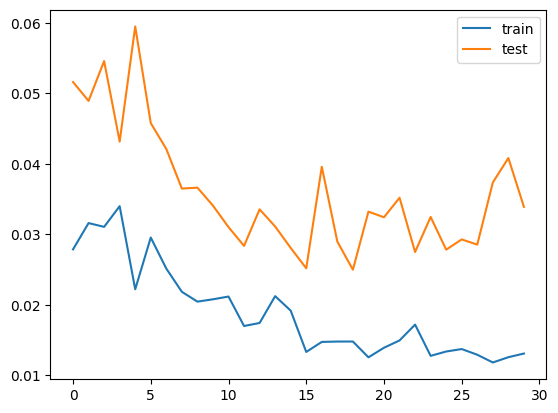

In [43]:
# design network
model = Sequential()
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -27:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -27:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Test RMSE: 30590.234
